### Imports

In [2]:
import torch
import torch_geometric
import torch.nn as nn
import explainer
import networks
import datasetLoader
import evaluation
import importlib
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import networkx as nx
from typing import Literal
import torch.nn.functional as fn
from torch_geometric.utils import k_hop_subgraph
import utils

importlib.reload(datasetLoader)
importlib.reload(networks)
importlib.reload(explainer)
importlib.reload(utils)
importlib.reload(evaluation)

<module 'evaluation' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\evaluation.py'>

### Parameters Explainer

In [3]:
batch_size = 32
sampled_graphs = 20

learning_rate_mlp = 0.003       #Paper: 0.003,
coefficientSizeReg = 0.05       #Paper: 0.05, code 0, codePyG 0.03
entropyReg = 0.01               #Paper: 1, code 0, codePyG 0.01
epochs_mlp = 20                 #Paper: 30 for all datasets => 20 enough for BA2Motif

# Temperature
t_0 =  5.0
t_T = 1.0                       #Paper says 2.0, Code seems to use 1.0 => 1.0 seems to work good

datasetName: Literal['BA2Motif','MUTAG'] = 'BA2Motif'
MUTAG = False

### Load and visualize data

Data(x=[25, 10], edge_index=[2, 50], y=[1])


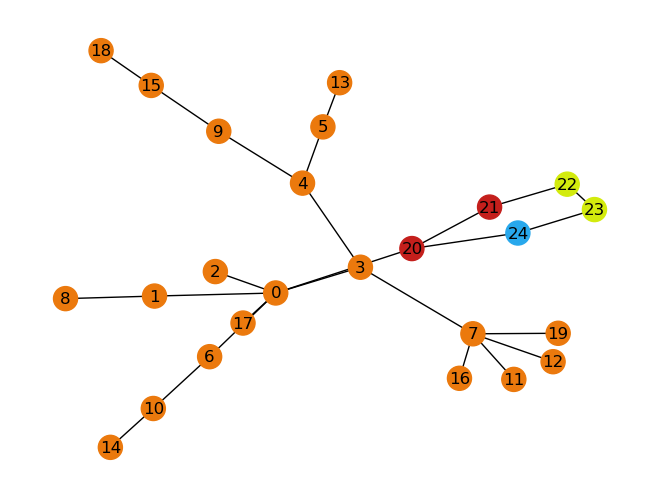

In [4]:
train_dataset, val_dataset, test_dataset = datasetLoader.loadGraphDataset(datasetName)               # TODO: adjs matrix is not compatible with GraphConv. Needs to be converted to edge_index (see RE_PGE datasets/utils)

print(train_dataset[0])

graph = Data(train_dataset[0].x, train_dataset[0].edge_index)

utils.plotGraph(graph, color_map=None, MUTAG=MUTAG)

train_loader = DataLoader(train_dataset, batch_size, True)             # TODO: Data not shuffled to match calculated embeddings to correct graphs! Should work now, as embeddings are calculated on the fly per batch
val_loader = DataLoader(val_dataset, batch_size, False)
test_loader = DataLoader(test_dataset, batch_size)

### Load GNN model

In [5]:
modelGraphGNN = networks.GraphGNN(features = train_dataset[0].x.shape[1], labels=2)     # Adjust according to data and task
modelGraphGNN.load_state_dict(torch.load("models/BA2Motif 100", weights_only=True))

<All keys matched successfully>

In [107]:
def weights_init(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)

### Training Loop Graph Classification Explainer

In [99]:
#torch.set_printoptions(threshold=10_000)
mlp = explainer.MLP()
mlp.apply(weights_init)

mlp_optimizer = torch.optim.Adam(params = mlp.parameters(), lr = learning_rate_mlp, maximize=False)

modelGraphGNN.eval()
for param in modelGraphGNN.parameters():
    param.requires_grad = False

for epoch in range(0, epochs_mlp) :
    mlp.train()
    mlp_optimizer.zero_grad()

    temperature = t_0*((t_T/t_0) ** ((epoch+1)/epochs_mlp))

    Loss = torch.FloatTensor([0])

    for batch_index, data in enumerate(train_loader):
        # MLP forward                                                           # shape embeddings[batch_index]: ~50 X 40 = Edges X hidden_embs_2Nodes
        w_ij = mlp.forward(modelGraphGNN, data.x, data.edge_index)               # shape: ~50 X 1 = Edges X MLP_out(edge_weight)

        sampleLoss = Loss = torch.FloatTensor([0])
        
        for k in range(0, sampled_graphs):
            # Sample with reparam trick via edge weights
            edge_ij = mlp.sampleGraph(w_ij, temperature)

            # TODO: This softmax is needed for the prediction of the downstream task and should probably be moved into the GNN model!!!
            # until then it is def needed here. Probably correct here, can also be found in og Explainer.call
            # TODO: Validate correct prediction on batches!!!
            pOriginal = fn.softmax(modelGraphGNN.forward(data.x, data.edge_index, data.batch), dim=1)
            pSample = fn.softmax(modelGraphGNN.forward(data.x, data.edge_index, data.batch, edge_weights=edge_ij), dim=1)

            # TODO: Validate loss function, True_one_hot labels needed??
            # TODO: Implement correct loss for each graph per batch => Should be good
            for graph_index in range(data.num_graphs):
                node_mask = data.batch == graph_index
                edge_mask = (node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]])

                # TODO: VALIDATE pOriginal and pSample pass both label predictions, not just correct one
                currLoss = mlp.loss(pOriginal[graph_index], pSample[graph_index], edge_ij[edge_mask], coefficientSizeReg, entropyReg)
                sampleLoss += currLoss
        
        Loss += sampleLoss / sampled_graphs
        
    Loss.backward()
    
    #Loss = Loss / len(train_loader.dataset)

    print(f"Epoch {epoch+1}, Loss: {Loss.item()}")

    #torch.nn.utils.clip_grad_norm_(mlp.parameters(), max_norm=2)

    mlp_optimizer.step()

    mlp.eval()
    
    evaluation.evaluateExplainerAUC(mlp, modelGraphGNN, val_dataset, MUTAG)
    out = mlp.forward(modelGraphGNN, val_dataset[0].x, val_dataset[0].edge_index)

    #print(f"MLP Output for first val graph in epoch {epoch+1}:")
    #print(out.squeeze(1))

    """for name, param in mlp.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.grad}")"""

Epoch 1, Loss: 157.37196350097656
AUC of ROC: 0.7471289038658142
BinaryAUROC: 0.5628997164003097
roc_auc_score: 1.0
Epoch 2, Loss: 144.5424346923828
AUC of ROC: 0.8792105317115784
BinaryAUROC: 0.7279165732186395
roc_auc_score: 1.0
Epoch 3, Loss: 146.75999450683594
AUC of ROC: 0.9310526251792908
BinaryAUROC: 0.807986912453065
roc_auc_score: 1.0
Epoch 4, Loss: 165.18214416503906
AUC of ROC: 0.953157901763916
BinaryAUROC: 0.8598333851819162
roc_auc_score: 1.0
Epoch 5, Loss: 132.19444274902344
AUC of ROC: 0.9510526657104492
BinaryAUROC: 0.9078481873494281
roc_auc_score: 1.0
Epoch 6, Loss: 167.15066528320312
AUC of ROC: 0.9289473295211792
BinaryAUROC: 0.9235198736823829
roc_auc_score: 1.0
Epoch 7, Loss: 139.2269287109375
AUC of ROC: 0.9378947019577026
BinaryAUROC: 0.9243658797739884
roc_auc_score: 1.0
Epoch 8, Loss: 169.08511352539062
AUC of ROC: 0.9442105889320374
BinaryAUROC: 0.9236378894974063
roc_auc_score: 1.0
Epoch 9, Loss: 139.55198669433594
AUC of ROC: 0.9442105889320374
BinaryAUROC

In [259]:
torch.save(mlp.state_dict(), f"models/compare/explainerBA2Motif_weightsCombined_Size0Ent01_tT1_AUC56_LEARNS_LOWEST")

In [58]:
mlp = networks.MLP(features = 40)     # Adjust according to data and task
mlp.load_state_dict(torch.load("models/explainerBA2Motif_sequential_batched64", weights_only=True))

<All keys matched successfully>

In [7]:
k = 5

data1 = test_dataset[31]

printLoader = DataLoader([data1], 1, False)

tensor([-0.9455, -1.7124, -3.7028, -0.9455, -0.5504, -2.9127, -1.1455, -0.5504,
         0.4012, -0.3801, -0.3801, -0.3801, -0.3801, -0.3801,  0.4012, -0.3548,
        -2.9127, -3.0607, -3.0607, -1.3344, -0.7299, -0.3548, -1.5845, -0.3801,
        -1.5845, -0.3801, -1.3344, -0.7299, -1.9140, -1.7124, -0.3801, -1.1455,
        -1.1125, -1.1125, -0.3801, -1.1125, -1.9140, -1.1125, -0.3801, -3.7028,
        -5.3476, -5.1051, -6.0994, -5.3476, -4.7266, -5.6922, -4.7266, -4.5485,
        -5.1051, -4.5485, -6.0994, -5.6922], grad_fn=<CopySlices>)
tensor([0.2798, 0.1529, 0.0241, 0.2798, 0.3658, 0.0515, 0.2413, 0.3658, 0.5990,
        0.4061, 0.4061, 0.4061, 0.4061, 0.4061, 0.5990, 0.4122, 0.0515, 0.0448,
        0.0448, 0.2084, 0.3252, 0.4122, 0.1702, 0.4061, 0.1702, 0.4061, 0.2084,
        0.3252, 0.1285, 0.1529, 0.4061, 0.2413, 0.2474, 0.2474, 0.4061, 0.2474,
        0.1285, 0.2474, 0.4061, 0.0241, 0.0047, 0.0060, 0.0022, 0.0047, 0.0088,
        0.0034, 0.0088, 0.0105, 0.0060, 0.0105, 0.002

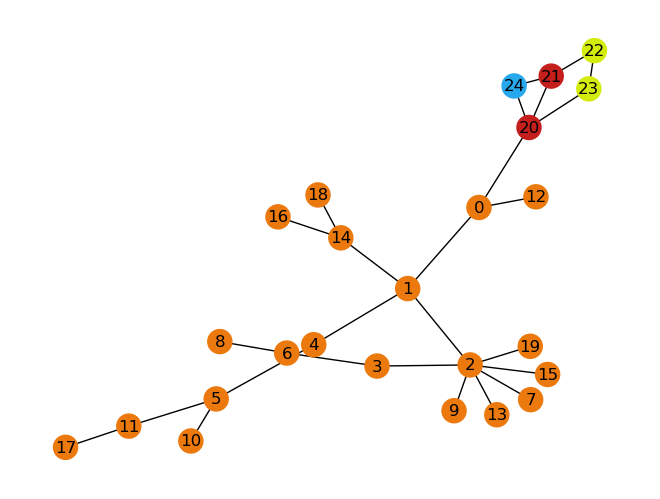

-----------------Sampled Graph-----------------


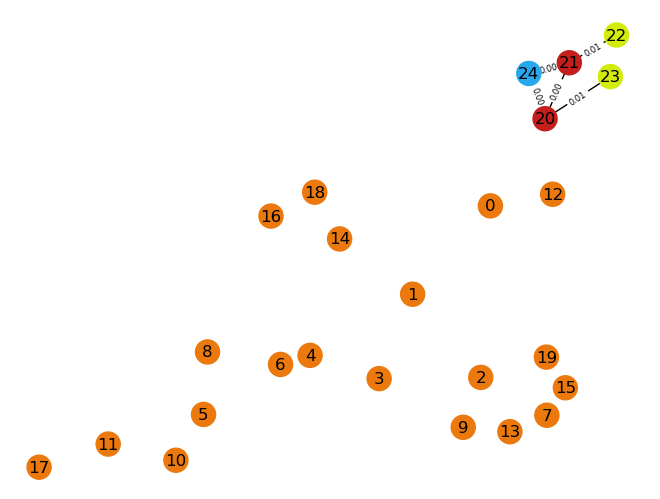

In [101]:
mlp.eval()
modelGraphGNN.eval()

w_ij = mlp.forward(modelGraphGNN, data1.x, data1.edge_index)

print(w_ij)

edge_ij = mlp.sampleGraph(w_ij, temperature)
print(edge_ij)

_, top_k_indices = torch.topk(edge_ij, k=k*2, largest=False)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = data1.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

# edge_index_masked and weights_masked to display top 5 edges; data1.edge_index and w_ij to display original graph
Gs = Data(x=data1.x, edge_index=edge_index_masked, edge_attr=weights_masked)

#print(Gs.edge_attr)
#print(weights_masked)

print("-----------------Original Graph-----------------")

pos = utils.plotGraph(data1, MUTAG=MUTAG)

print("-----------------Sampled Graph-----------------")

pos1 = utils.plotGraph(Gs, pos=pos, color_map=None, edge_weights=True, MUTAG=MUTAG)

In [12]:
startNode = 0

print("-----------------3 Hop neighbourhood-----------------")

posH, G_hop = utils.plotKhopGraph(startNode, data1.x, data1.edge_index, pos=pos, color_map=None)

-----------------3 Hop neighbourhood-----------------


NameError: name 'pos' is not defined

#### Calculate AUC between explanation edge probabilites and ground truth edges

AUC of ROC: 1.0
BinaryAUROC: 0.9928983779338355
roc_auc_score: 0.9999999999999999


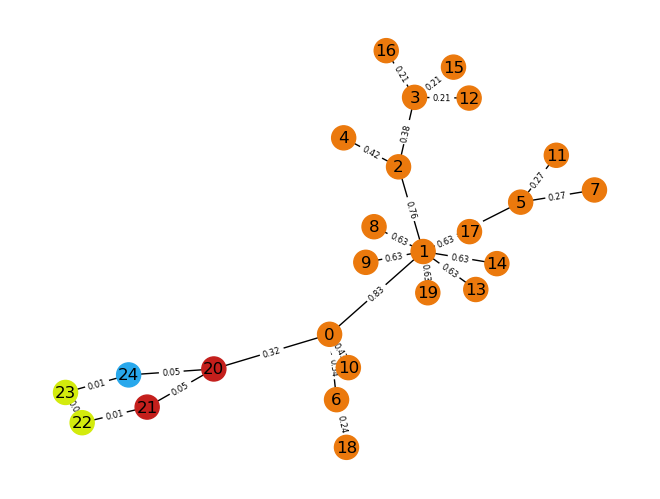

In [102]:
import evaluation
importlib.reload(evaluation)
# TODO: Work on different batch sizes

# TODO: Not working? Flips edge weights
data = evaluation.evaluateExplainerAUC(mlp, modelGraphGNN, test_dataset, MUTAG)
w_ij = mlp.forward(modelGraphGNN, data.x, data.edge_index)
edge_ij = mlp.sampleGraph(w_ij, temperature)

Graph = Data(x=data.x,edge_index=data.edge_index,edge_attr=edge_ij.detach())
pos1 = utils.plotGraph(Graph, pos=None, color_map=None, edge_weights=True, MUTAG=MUTAG)